In [1]:
import numpy as np
import gdal
import ogr, osr
import matplotlib.pyplot as plt
from rasterio import plot
import earthpy.plot as ep
import scipy as sp
import scipy.interpolate
chm_dataset = gdal.Open('output/clip_NDRE/NDRE_T0 P1.tif')

In [2]:
#Display the dataset dimensions, number of bands, driver, and geotransform 
cols = chm_dataset.RasterXSize; print('# of columns:',cols)
rows = chm_dataset.RasterYSize; print('# of rows:',rows)
print('# of bands:',chm_dataset.RasterCount)
print('driver:',chm_dataset.GetDriver().LongName)


# of columns: 468
# of rows: 480
# of bands: 1
driver: GeoTIFF


In [3]:
print('projection:',chm_dataset.GetProjection())

projection: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [4]:
print('geotransform:',chm_dataset.GetGeoTransform())

geotransform: (-70.89514818759987, 5.267371250802094e-07, 0.0, -33.767816955596, 0.0, -5.267371250802094e-07)


In [5]:
chm_mapinfo = chm_dataset.GetGeoTransform()
xMin = chm_mapinfo[0]
yMax = chm_mapinfo[3]

xMax = xMin + chm_dataset.RasterXSize/chm_mapinfo[1] #divide by pixel width 
yMin = yMax + chm_dataset.RasterYSize/chm_mapinfo[5] #divide by pixel height (note sign +/-)
chm_ext = (xMin,xMax,yMin,yMax)
print('chm raster extent:',chm_ext)


chm raster extent: (-70.89514818759987, 888488660.4217014, -911270527.4261242, -33.767816955596)


In [6]:
chm_raster = chm_dataset.GetRasterBand(1)
import rasterio
dataset = rasterio.open('output/clip_NDRE/NDRE_T0 P1.tif')
#chm_array=dataset.read((1,2,3,4)) 
noDataVal = chm_raster.GetNoDataValue(); print('no data value:',noDataVal)
scaleFactor = chm_raster.GetScale(); print('scale factor:',scaleFactor)
chm_stats = chm_raster.GetStatistics(True,True)
print('SERC CHM Statistics: Minimum=%.2f, Maximum=%.2f, Mean=%.3f, StDev=%.3f' % 
      (chm_stats[0], chm_stats[1], chm_stats[2], chm_stats[3]))

no data value: -10000.0
scale factor: 1.0
SERC CHM Statistics: Minimum=0.05, Maximum=0.54, Mean=0.223, StDev=0.119


In [7]:
dataset.descriptions

(None,)

In [8]:
data = dataset.read([1])

In [9]:
data.shape

(1, 480, 468)

In [10]:
chm_array = chm_dataset.GetRasterBand(1).ReadAsArray(0,0,cols,rows).astype(np.float)
chm_array[chm_array==noDataVal]=np.nan #Assign CHM No Data Values to NaN
chm_array=chm_array/scaleFactor
print('SERC CHM Array:\n',chm_array) #display array values

SERC CHM Array:
 [[0.11493824 0.1159981  0.11969363 ... 0.14193726 0.1520918         nan]
 [0.117599   0.12377674 0.12750739 ... 0.15959875 0.15924604        nan]
 [0.12021773 0.1239873  0.11819968 ... 0.16483261 0.14812109        nan]
 ...
 [0.38090509 0.37944591 0.33738947 ... 0.27107018 0.25546026        nan]
 [0.29800761 0.27482054 0.23777382 ... 0.29133338 0.2918157         nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [11]:
# Calculate the % of pixels that are NaN and non-zero:
pct_nan = np.count_nonzero(np.isnan(chm_array))/(rows*cols)
print('% NaN:',round(pct_nan*100,2))
print('% non-zero:',round(100*np.count_nonzero(chm_array)/(rows*cols),2))

% NaN: 0.42
% non-zero: 100.0


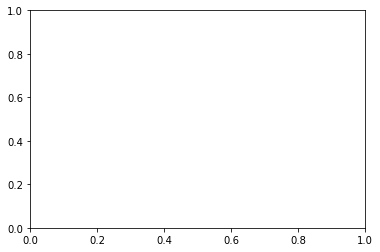

In [12]:
def plot_spatial_array(band_array,spatial_extent,colorlimit,ax=plt.gca(),title='',cmap_title='',colormap=''):
    plot = plt.imshow(band_array,extent=spatial_extent,clim=colorlimit);
    print(spatial_extent)
    cbar = plt.colorbar(plot,aspect=40); 
    plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); 
    ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

Text(0, 0.5, 'Relative Frequency')

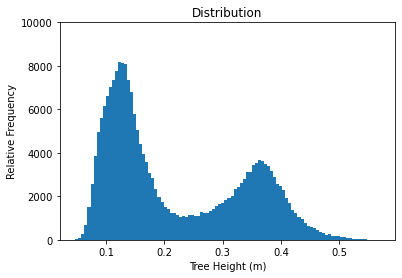

In [13]:
#https://www.neonscience.org/classify-raster-thresholds-2018-py
plt.hist(chm_array[~np.isnan(chm_array)],100);
ax = plt.gca()
ax.set_ylim([0,1e4]) #adjust the y limit to zoom in on area of interest
plt.title('Distribution')
plt.xlabel('Tree Height (m)'); plt.ylabel('Relative Frequency')

(-70.89514818759987, 888488660.4217014, -911270527.4261242, -33.767816955596)


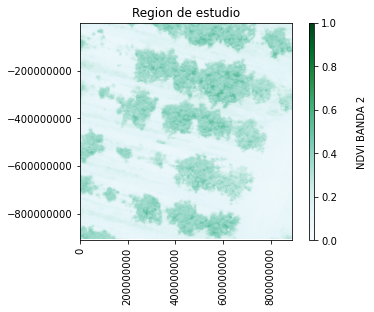

In [14]:
plot_spatial_array(chm_array,
                chm_ext,
                (0,1),
                title='Region de estudio',
                cmap_title='NDVI BANDA 2',
                colormap='BuGn')

In [15]:
import copy
chm_reclass = copy.copy(chm_array)
#chm_reclass[np.where(chm_array==0)] = 1 # CHM = 0 : Class 1
#chm_reclass[np.where((chm_array>0) & (chm_array<=20))] = 2 # 0m < CHM <= 10m - Class 2
#chm_reclass[np.where((chm_array>20) & (chm_array<=60))] = 3 # 10m < CHM <= 20m - Class 3
chm_reclass[np.where((chm_array>=0) & (chm_array<=0.26))] = 4 # 20m < CHM <= 30m - Class 4
chm_reclass[np.where(chm_array>0.26)] = 5 # CHM > 30m - Class 5

<ipython-input-15-9f9e565ac847>:6: RuntimeWarning: invalid value encountered in greater_equal
  chm_reclass[np.where((chm_array>=0) & (chm_array<=0.26))] = 4 # 20m < CHM <= 30m - Class 4
<ipython-input-15-9f9e565ac847>:6: RuntimeWarning: invalid value encountered in less_equal
  chm_reclass[np.where((chm_array>=0) & (chm_array<=0.26))] = 4 # 20m < CHM <= 30m - Class 4
<ipython-input-15-9f9e565ac847>:7: RuntimeWarning: invalid value encountered in greater
  chm_reclass[np.where(chm_array>0.26)] = 5 # CHM > 30m - Class 5


<class 'numpy.ndarray'>


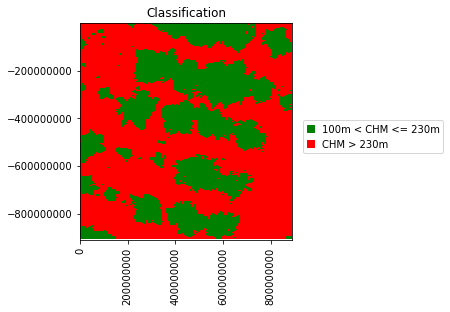

In [16]:
import matplotlib.colors as colors
print(type(chm_reclass))
plt.figure(); 
cmapCHM = colors.ListedColormap(['red','green'])
plt.imshow(chm_reclass,extent=chm_ext,cmap=cmapCHM)
plt.title('Classification')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees

# Create custom legend to label the four canopy height classes:
import matplotlib.patches as mpatches
#class1_box = mpatches.Patch(color='lightblue', label='CHM = 0m')
#class2_box = mpatches.Patch(color='yellow', label='0m < CHM <= 50m')
#class3_box = mpatches.Patch(color='orange', label='50m < CHM <= 100m')
class4_box = mpatches.Patch(color='green', label='100m < CHM <= 230m')
class5_box = mpatches.Patch(color='red', label='CHM > 230m')

ax.legend(handles=[class4_box,class5_box],
          handlelength=0.7,bbox_to_anchor=(1.05, 0.4),loc='lower left',borderaxespad=0.)

In [17]:
print(chm_reclass[0][1])

4.0


In [19]:
img = plt.imread("output/clip_NDRE/NDRE_T0 P1.tif") 
  
# fetch the height and width 
height, width, _ = img.shape 
  
# area is calculated as “height x width” 
area = height * width
total = height + width
  
# display the area 
print("Area of the image is : ", area)
print("total pixel: ", total)

Area of the image is :  224640
total pixel:  948


In [ ]:
print(chm_reclass)

In [24]:
total=[]
for n in range(chm_reclass.shape[0]):
    for m in range(chm_reclass.shape[1]):
        print(chm_reclass[n][m])
        if chm_reclass[n][m]== 5:
            total.append(1)
        else:
            total.append(0)
area_verde=sum(total)

4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
5.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
nan
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
5.0
5.0
5.0
5.0
nan
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
nan
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
nan
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


5.0
5.0
5.0
5.0
4.0
5.0
nan
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
5.0
4.0
5.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0
4.0


In [25]:
print("porcentaje color verde :", area_verde*100/224640)

porcentaje color verde : 36.462339743589745


In [18]:
#plt.imshow(chm_reclass, interpolation='nearest', cmap='gray')
#plt.show()

In [37]:
print(chm_reclass[1][:])

[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 5. 4. 5. 4. 4. 4. 4. 5. 4. 4. 5. 5. 5. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 4. 4. 4. 4. 5. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 5. 4. 4. 4. 4. 4. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5.

In [ ]:
def calcPercentage(self, msk): 
    ''' 
    returns the percentage of white in a binary image 
    ''' 
    height, width = msk.shape[:2] 
    num_pixels = height * width 
    count_white = cv2.countNonZero(msk) 
    percent_white = (count_white/num_pixels) * 100 
    percent_white = round(percent_white,2) 
    return percent_white 

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import match_template
from PIL import Image

In [ ]:
# Interactive selection of points

#define empty cells 
puntosinteres = []

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
ax.imshow(chm_reclass, cmap=plt.cm.gray)
text=ax.text(0,0, "", va="bottom", ha="left")


#interactive function that stores points clicked on the image
def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)
    puntosinteres.append([event.xdata, event.ydata])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [ ]:

# amount of points clicked
len(puntosinteres)


In [ ]:

#plot points over the image and select more if you want
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.imshow(chm_reclass, cmap=plt.cm.gray)
ax.scatter([x[0] for x in puntosinteres],[y[1] for y in puntosinteres],c='red', marker='+', s=8)
text=ax.text(0,0, "", va="bottom", ha="left")

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)
    puntosinteres.append([event.xdata, event.ydata])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

#show all the points of interest, please be careful to have a complete image, otherwise the model wont run
fig, ax = plt.subplots(len(puntosinteres)//6+1, 6)
i = 0
for item in puntosinteres:
    xinteres = int(item[0])
    yinteres = int(item[1])
    radio = 20
    ax[i//6,i-i//6*6].imshow(chm_reclass)
    ax[i//6,i-i//6*6].plot(xinteres,yinteres,color='red', linestyle='dashed', marker='+',
     markerfacecolor='blue', markersize=8)
    ax[i//6,i-i//6*6].set_xlim(xinteres-radio,xinteres+radio)
    ax[i//6,i-i//6*6].set_ylim(yinteres-radio,yinteres+radio)
    ax[i//6,i-i//6*6].axis('off')
    ax[i//6,i-i//6*6].set_title(i)
    i+=1


In [ ]:
# Match the image to the template

listaresultados = []
for punto in puntosinteres:
    xinteres = int(punto[0])
    yinteres = int(punto[1])
    radio=30
    print(chm_reclass)
    imagenband = chm_reclass[:,:]
    templateband = chm_reclass[yinteres-radio:yinteres+radio,xinteres-radio:xinteres+radio]
    result= match_template(imagenband, templateband)
    result = np.where(result>0.85)
    listaresultados.append(result)

# Plot interpreted points over the image

from itertools import cycle
cycol = cycle('bgrcmk')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

i = 1
for lista in listaresultados:
    ax.plot(lista[1],lista[0], '.', linewidth=0, markerfacecolor=next(cycol), label=i)
    i+=1
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax.imshow(chm_reclass[radio:-radio,radio:-radio])

In [ ]:
# Cluster analisys with Birch algorithm

datalist = [np.asarray(pares).T for pares in listaresultados]
print(len(datalist))
datalist = np.vstack(datalist)
print(datalist)

from sklearn.cluster import Birch
brc = Birch(branching_factor=10000, n_clusters=None, threshold=10, compute_labels=True)
brc.fit(datalist)
puntosbirch = brc.subcluster_centers_
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.scatter(puntosbirch[:,[1]],puntosbirch[:,[0]], marker='+',color='red')
ax.imshow(chm_reclass[radio:-radio,radio:-radio])

len(puntosbirch)

In [ ]:
from osgeo import gdal, osr
import numpy

ds = gdal.Open('output/clip_NDVI/NDVI_T2 P6.tif')
band = ds.GetRasterBand(1)
myarray = numpy.array(band.ReadAsArray())
selection = numpy.logical_or(myarray >= 255, myarray <= 10)

new_array = [ [0 for i in range(band.XSize)] for j in range(band.YSize)]
print(new_array)
for i, item in enumerate(myarray):
    for j, element in enumerate(item):
        if selection[i][j] == True:
            new_array[i][j] = myarray[i][j]
        else:
            new_array[i][j] = -999

geotransform = ds.GetGeoTransform()
wkt = ds.GetProjection()

# Create gtif file
driver = gdal.GetDriverByName("GTiff")
output_file = "raster_geotiff.tif"
dst_ds = driver.Create(output_file,
                       band.XSize,
                       band.YSize,
                       1,
                       gdal.GDT_Int16)

new_array = numpy.array(new_array)
#writting output raster
dst_ds.GetRasterBand(1).WriteArray( new_array )
#setting nodata value
dst_ds.GetRasterBand(1).SetNoDataValue(-999)
#setting extension of output raster
# top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
dst_ds.SetGeoTransform(geotransform)
# setting spatial reference of output raster
srs = osr.SpatialReference()
srs.ImportFromWkt(wkt)
dst_ds.SetProjection( srs.ExportToWkt() )
#Close output raster dataset

ds = None
dst_ds = None

# save corners


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
files=glob.glob('output/process_image_NDVI/B1/*.tif')
for n in files:
    image = cv2.imread(n)
    print(type(image))
    #image = chm_array
    output = image.copy()
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imgr = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(2,2))
    imgray_ad = clahe.apply(imgr)#adaptive
    imgray = cv2.equalizeHist(imgr)#global


    res = np.hstack((imgray,imgray_ad))#so we can plot together
    #gray = chm_reclass
    circles = cv2.HoughCircles(imgray, cv2.HOUGH_GRADIENT,12, 80, param1=8,param2=23 ,
                               minRadius=3,maxRadius=50)
    #print(circles)
    dataset=pd.DataFrame(columns=['x coord','y coord', 'ratio'])
    #print(circles.shape[2])
    circles2=circles.reshape(( circles.shape[1], circles.shape[2]))
    #print(circles2)
    dataset=pd.DataFrame(circles2,columns=['x coord','y coord', 'ratio'])
    print(dataset)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(output, (x, y), r, (255,0,0),4)
            cv2.rectangle(output, (x - 3, y - 3), (x + 3, y + 3), (1, 0, 255), -1)
        plt.subplot(121), plt.imshow(imgray, cmap="gray"), plt.title(n.split('/')[-1].split('.')[0])
        plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(output, cmap="gray"), plt.title("corners")
        plt.xticks([]), plt.yticks([])
        plt.savefig('output/corners_NDVI/B1/'+n.split('/')[-1].split('.')[0]+'.jpg')

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
files=glob.glob('output/clip_NDVI/*.tif')
for n in files:
    #image = cv2.imread("output/clip_NDVI/NDVI_T2 P6.tif")
    image = cv2.imread(n)
    print(type(image))
    #image = chm_array
    output = image.copy()
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imgr = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=100.0, tileGridSize=(8,8))
    imgray_ad = clahe.apply(imgr)#adaptive
    imgray = cv2.equalizeHist(imgr)#global
    res = np.hstack((imgray,imgray_ad))#so we can plot together
    #gray = chm_reclass
    circles = cv2.HoughCircles(imgray, cv2.HOUGH_GRADIENT,30, 60, param1=70, param2=30,
                               minRadius=20,maxRadius=50)
    print(circles)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(output, (x, y), r, (0, 250, 0),4)
            #cv2.rectangle(output, (x - 3, y - 3), (x + 3, y + 3), (1, 0, 255), -1)
        plt.subplot(121), plt.imshow(imgray_ad, cmap="gray"), plt.title("corners")
        plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(output, cmap="gray"), plt.title("corners")
        plt.xticks([]), plt.yticks([])
        plt.show()
        plt.subplot(121), plt.imshow(imgray, cmap="gray"), plt.title("corners")
        plt.xticks([]), plt.yticks([])
        plt.subplot(122), plt.imshow(res, cmap="gray"), plt.title("corners")
        plt.xticks([]), plt.yticks([])

In [ ]:
import cv2 as cv2
import matplotlib.pyplot as plt
img_color = cv2.imread('output/process_image_NDVI/B1/NDVI_T2 P6.tif')
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

image = cv2.GaussianBlur(img_gray, (5, 5),1)

thresh = cv2.adaptiveThreshold(image,115,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,23,2)

contours,hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours

contour_list = []
for contour in contours:
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    # Filter based on length and area
    if (134 < len(approx) < 555) & (24466 >area > 180):
        print(area)
        contour_list.append(contour)

cv2.drawContours(img_color, contour_list,  -1, (255,0,0), 2)
cv2.imshow('Objects Detected',img_color)
cv2.waitKey(5000)

# Corte de imagen

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
image = cv2.imread('output/clip_NDVI/NDVI_T2 P6.tif')
ancho = image.shape[1] #columnas
alto = image.shape[0] # filas
# Rotación
M = cv2.getRotationMatrix2D((ancho//2,alto//2),23,1)
imageOut = cv2.warpAffine(image,M,(ancho,alto))
plt.imshow(imageOut, cmap="gray")
#cv2.imshow('Imagen de entrada',image)
#cv2.imshow('Imagen de salida',imageOut)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

image = cv2.imread('output/clip_NDVI/NDVI_T2 P6.tif')
infile = 'output/clip_NDVI/test.png'
chopsize = 150

img = Image.open(infile)
width, height = img.size

# Save Chops of original image
for x0 in range(0, width, chopsize):
    for y0 in range(0, height, chopsize):
        box = (x0, y0,
             x0+chopsize if x0+chopsize <  width else  width - 1,
             y0+chopsize if y0+chopsize < height else height - 1)
        print('%s %s' % (infile, box))
        img.crop(box).save('%s.x%03d.y%03d.tif' % (infile.replace('.tif',''), x0, y0))


# Deteccion de arboles unitario


In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

image = cv2.imread('output/tif/NDVI.tif')

print(type(image))
#image = chm_array
output = image.copy()
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imgr = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(2,2))
imgray_ad = clahe.apply(imgr)#adaptive
imgray = cv2.equalizeHist(imgr)#global


res = np.hstack((imgray,imgray_ad))#so we can plot together
#gray = chm_reclass
circles = cv2.HoughCircles(imgray, cv2.HOUGH_GRADIENT,17, 54, param1=1, param2=69 ,
                           minRadius=5,maxRadius=450)
print(circles)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(output, (x, y), r, (30,255, 0),4)
        #cv2.rectangle(output, (x - 3, y - 3), (x + 3, y + 3), (1, 0, 255), -1)
    plt.subplot(121), plt.imshow(imgray, cmap="gray"), plt.title("corners")
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(output, cmap="gray"), plt.title("corners")
    plt.xticks([]), plt.yticks([])
    plt.show()

# Contornos

In [ ]:
import cv2 as cv2
import matplotlib.pyplot as plt
img_color = cv2.imread('output/clip_NDVI/NDVI_T2 P6.tif')
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

image = cv2.GaussianBlur(img_gray, (5, 5),1)

thresh = cv2.adaptiveThreshold(image,125,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,37,1)

contours,hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours

contour_list = []
for contour in contours:
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    # Filter based on length and area
    if (12 < len(approx) < 3463) & (23544 >area > 200):
        print(area)
        contour_list.append(contour)

cv2.drawContours(img_color, contour_list,  -1, (255,0,0), 2)
cv2.imshow('Objects Detected',img_color)
cv2.waitKey(5000)

In [ ]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [ ]:

dirname = 'output/process_image_NDVI/B1/'

imgpath = dirname +os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tif)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))
https://www.aprendemachinelearning.com/deteccion-de-objetos-con-python-yolo-keras-tutorial/


In [ ]:

labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)


In [ ]:
import image_slicer

image_slicer.slice('/home/nvaldebenito/Documents/40_trabajo_jsalinas/output/tif/NDVI.tif', 64)

# Rotar imagen

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from osgeo import gdal, osr
import numpy as np


image = cv2.imread('/home/nvaldebenito/Documents/40_trabajo_jsalinas/output/tif/NDVI.tif').astype(np.float)
# Split into 3 channels, discarding the first and saving the second as R, third as NearIR
_, R, NearIR = cv2.split(image)

# Compute NDVI values for each pixel
image = (NearIR - R) / (NearIR + R + 0.001)
ancho = image.shape[1] #columnas
alto = image.shape[0] # filas
# Rotación
M = cv2.getRotationMatrix2D((ancho//2,alto//2),15,1)

imageOut = cv2.warpAffine(image,M,(ancho,alto))
#imgr = cv2.cvtColor(imageOut,cv2.COLOR_BGR2GRAY)

#imgray = cv2.equalizeHist(imgr)#global

plt.imshow(imageOut)
print(imageOut.shape)
im = Image.fromarray(imageOut)
im.save('test.tif')
print(imageOut.max())
print(imageOut.min())

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
try:
    from PIL import Image
except ImportError:
    import Image

# Open image file
image = Image.open('test.tif')

my_dpi=500.


# Set up figure
fig=plt.figure(figsize=(float(image.size[0])/my_dpi,float(image.size[1])/my_dpi),dpi=my_dpi)
ax=fig.add_subplot(111)

# Remove whitespace from around the image
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

# Set the gridding interval: here we use the major tick interval
myInterval=100.
loc = plticker.MultipleLocator(base=myInterval)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)

# Add the grid
ax.grid(which='major', axis='both', linestyle='-')

# Add the image
ax.imshow(image)

# Find number of gridsquares in x and y direction
nx=abs(int(float(ax.get_xlim()[1]-ax.get_xlim()[0])/float(myInterval)))
ny=abs(int(float(ax.get_ylim()[1]-ax.get_ylim()[0])/float(myInterval)))

# Add some labels to the gridsquares
for j in range(ny):
    y=myInterval/2+j*myInterval
    for i in range(nx):
        x=myInterval/2.+float(i)*myInterval
        #ax.text(x,y,'{:d}'.format(i+j*nx),color='w',ha='center',va='center')

# Save the figure
fig.savefig('myImageGrid.tiff',dpi=my_dpi)

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
n='myImageGrid.tiff'
my_dpi=500.
#image = cv2.imread("output/clip_NDVI/NDVI_T2 P6.tif")
image = cv2.imread(n)
print(type(image))
#image = chm_array
output = image.copy()
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imgr = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=100.0, tileGridSize=(8,8))
imgray_ad = clahe.apply(imgr)#adaptive
imgray = cv2.equalizeHist(imgr)#global
res = np.hstack((imgray,imgray_ad))#so we can plot together
#gray = chm_reclass
circles = cv2.HoughCircles(imgray, cv2.HOUGH_GRADIENT,20, 60, param1=70, param2=3,
                           minRadius=10,maxRadius=50)
print(circles)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(output, (x, y), r, (2, 250, 0),4)
        #cv2.rectangle(output, (x - 3, y - 3), (x + 3, y + 3), (1, 0, 255), -1)
    #plt.subplot(121), plt.imshow(imgray_ad, cmap="gray"), plt.title("corners")
    #plt.xticks([]), plt.yticks([])
    #plt.subplot(122), 
    plt.imshow(output, cmap="gray"), plt.title("corners")
    plt.xticks([]), plt.yticks([])    
    plt.savefig('corners.tiff', dpi=my_dpi)
    plt.show()

In [ ]:
import cv2 as cv2
import matplotlib.pyplot as plt
img_color = cv2.imread('myImageGrid.tiff')
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

image = cv2.GaussianBlur(img_gray, (5, 5),1)

thresh = cv2.adaptiveThreshold(image,125,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY_INV,37,1)

contours,hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours

contour_list = []
for contour in contours:
    approx = cv2.approxPolyDP(contour,0.01*cv2.arcLength(contour,True),True)
    area = cv2.contourArea(contour)
    # Filter based on length and area
    if (12 < len(approx) < 3463) & (23544 >area > 200):
        print(area)
        contour_list.append(contour)

cv2.drawContours(img_color, contour_list,  -1, (255,0,0), 2)
cv2.imshow('Objects Detected',img_color)
cv2.waitKey(5000)